# ROCs from scratch

In [327]:
from utils import *
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, auc
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import json
import seaborn as sns
import glob
import scipy.stats as st


def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

def conf_int(data, alpha=0.95, dist='t'):
    if dist == 't':
        return st.t.interval(alpha, data.shape[0]-1, loc=data.mean(axis=0), scale=st.sem(data, axis=0))
    elif dist == 'norm':
        return st.norm.interval(alpha, loc=data.mean(axis=0), scale=st.sem(data, axis=0))
    raise NotImplementedError


ci_alpha = 0.95
exp_name = 'extremeTest_lowData'
metrics_dir = os.path.join('./roc_metrics', exp_name)
plot_title = 'T&S in Low Data Setting: Extreme Illumination'
# plot_title = exp_name
save_dir = './vss_plots'
plt_name = exp_name

fnames = [[os.path.join(metrics_dir, subdir, fname) for fname in listdir_nohidden(os.path.join(metrics_dir, subdir))] for subdir in listdir_nohidden(metrics_dir)]

In [328]:
all_data = []
all_metrics = []
for subdir in fnames:
    subdir_data = []
    subdir_metrics = []
    for fname in filter(lambda x: 'roc_data_' in x and '.json' in x, subdir):
        with open(fname, 'r') as f:
            data = json.load(f)
            data['subdir'] = os.path.basename(os.path.dirname(fname))
            subdir_data.append(data)
    all_data.append(subdir_data)
    
    for fname in filter(lambda x: 'metrics_' in x and '.json' in x, subdir):
        with open(fname, 'r') as f:
            data = json.load(f)
#             print(data)
            data['subdir'] = os.path.basename(os.path.dirname(fname))
            subdir_metrics.append(data)
    all_metrics.append(subdir_metrics)
    
all_fprs = []
all_tprs = []
all_aucs = []
all_subdirs = []

for subdir in sorted(all_data, key=lambda x: x[0]['subdir']):
    raw_fprs = []
    raw_tprs = []
    raw_aucs = []
    for trial in subdir:
        raw_fprs.append(trial['fprs'])
        raw_tprs.append(trial['tprs'])
        raw_aucs.append(trial['auc_score'])
    fprs = np.array(raw_fprs)
    tprs = np.array(raw_tprs)
    aucs = np.array(raw_aucs)
    all_fprs.append(fprs)
    all_tprs.append(tprs)
    all_aucs.append(aucs)
    all_subdirs.append(trial['subdir'])

print(all_subdirs)

all_acc = []
all_mcc = []
all_f1  = []
all_auc = []
all_metrics_subdirs = []

for subdir in sorted(all_metrics, key=lambda x: x[0]['subdir']):
    raw_acc = []
    raw_mcc = []
    raw_f1  = []
    raw_auc = []
    for trial in subdir:
        raw_acc.append(trial['accuracy'])
        raw_mcc.append(trial['mcc'])
        raw_f1.append(trial['f1_score'])
        raw_auc.append(trial['auc'])
    all_acc.append(np.array(raw_acc))
    all_mcc.append(np.array(raw_mcc))
    all_f1.append(np.array(raw_f1))
    all_auc.append(np.array(raw_auc))
    all_metrics_subdirs.append(trial['subdir'])

print(all_metrics_subdirs)

def print_metrics(metric, prec=3):
    m = metric.mean()
    lb, ub = conf_int(metric)
    assert round(ub-m, 6) == round(m-lb, 6)  # close enough
    print(f'\t{str(round(m, prec))[1:]}$\pm${str(round(m-lb, prec))[1:]}')

for idx, (acc, mcc, f1, auc, subdir) in enumerate(zip(all_acc, all_mcc, all_f1, all_auc, all_subdirs)):
    print(subdir)
    print('\tAccuracy', end='')
    print_metrics(acc)
    print('\tF1 score', end='')
    print_metrics(f1)
    print('\tMCC\t', end='')
    print_metrics(mcc)
    print('\tAUC\t', end='')
    print_metrics(auc)

['HOG_extremeTemplates', 'HOG_extremeTemplates_lowData', 'HOG_normalTemplates', 'HOG_normalTemplates_lowData']
['HOG_extremeTemplates', 'HOG_extremeTemplates_lowData', 'HOG_normalTemplates', 'HOG_normalTemplates_lowData']
HOG_extremeTemplates
	Accuracy	.562$\pm$.065
	F1 score	.457$\pm$.077
	MCC		.135$\pm$.142
	AUC		.538$\pm$.051
HOG_extremeTemplates_lowData
	Accuracy	.55$\pm$.074
	F1 score	.563$\pm$.075
	MCC		.102$\pm$.148
	AUC		.564$\pm$.096
HOG_normalTemplates
	Accuracy	.626$\pm$.035
	F1 score	.403$\pm$.096
	MCC		.374$\pm$.06
	AUC		.81$\pm$.036
HOG_normalTemplates_lowData
	Accuracy	.75$\pm$.039
	F1 score	.7$\pm$.091
	MCC		.532$\pm$.049
	AUC		.808$\pm$.074


/Users/dylan/.pyenv/versions/faces/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/dylan/.pyenv/versions/faces/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/dylan/.pyenv/versions/faces/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/dylan/.pyenv/versions/faces/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/dylan/.pyenv/versions/faces/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/dylan/.pyenv/versions/faces/

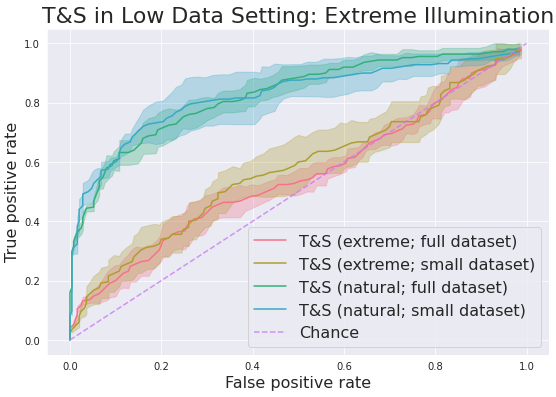

In [330]:
colors = sns.color_palette("husl", len(all_subdirs)+1)
# colors[0], colors[-1] = colors[-1], colors[0]

labels = ['T&S (natural)', 'VGG-Face (natural)', 'VGG16 (ImageNet)']
labels = ['T&S (extreme)', 'T&S (natural)', 'VGG-Face (extreme)', 'VGG-Face (natural)', 'VGG16 (ImageNet)']
labels = ['T&S (full dataset)', 'T&S (small dataset)',]
labels = ['T&S (extreme; full dataset)', 'T&S (extreme; small dataset)', 'T&S (natural; full dataset)', 'T&S (natural; small dataset)',]
# labels = all_subdirs

with sns.axes_style('darkgrid'):
    # plt.title('HOG vs. VGG-Face: Natural Illumination')
    fig = plt.figure()
    fig.patch.set_alpha(0.0)
    fig.set_size_inches(9, 6)
    plt.gca().patch.set_alpha(1.0)
    
    plt.title(plot_title, fontsize=22)
    plt.xlabel('False positive rate', fontsize=16)
    plt.ylabel('True positive rate', fontsize=16)

    for idx, (fprs, tprs, aucs, subdir, lab) in enumerate(zip(all_fprs, all_tprs, all_aucs, all_subdirs, labels)):
        
        fprs_mean = fprs.mean(axis=0)
        tprs_mean = tprs.mean(axis=0)
        tprs_std = tprs.std(axis=0)
        aucs_mean = aucs.mean()
        aucs_std = aucs.std()

#         tprs_lower, tprs_upper = [], []
#         for tp in tprs:
#             lb, ub = conf_int(tp)
#             tprs_lower.append(lb)
#             tprs_upper.append(ub)

        tprs_lower, tprs_upper = conf_int(tprs)
        tprs_lower = np.maximum(tprs_lower, 0.)
        tprs_upper = np.minimum(tprs_upper, 1.)

        
        plt.plot(fprs_mean, tprs_mean, c=colors[idx],
#                  label=f"{subdir.split('_')[0]}: mean ± 1 std. dev.; AUC={round(aucs_mean, 3)}±{round(aucs_std, 3)}"
#                  label=f"{subdir}"
                 label=f"{lab}"
                )
        plt.fill_between(fprs_mean, tprs_lower, tprs_upper, color=colors[idx], alpha=0.3)

#         for j in range(fprs.shape[0]):
#             plt.plot(fprs[j], tprs[j], alpha=.3, c=colors[idx], linewidth=0.5)

    plt.plot([0, 1], [0, 1], linestyle='--', color=colors[-1], label='Chance', alpha=.8)

    plt.legend(fontsize=16)

    plt.savefig(os.path.join(save_dir, f'{plt_name}.png'))